# Setup
YouTube Data API key  
https://developers.google.com/youtube/v3/getting-started  

Gemini Pro API Key  
https://ai.google.dev/pricing  
https://makersuite.google.com/app/apikey

Put keys into Colab's Secrets store.

In [ ]:
from google.colab import userdata
YOUTUBE_DATA_API_KEY = userdata.get('YOUTUBE_DATA_API_KEY')
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')

In [ ]:
# Colab already has google libraries installed
# Reference: https://developers.google.com/youtube/v3/quickstart/python
# !pip install --upgrade google-api-python-client
# !pip install --upgrade google-auth-oauthlib google-auth-httplib2

!pip install youtube-transcript-api

# Colab already has Gemini libraries installed
# Reference: https://ai.google.dev/tutorials/python_quickstart?hl=en
# !pip install -q -U google-generativeai

!pip install chromadb
!pip install sentence-transformers # For converting text to vector embeddings


In [ ]:
# YouTube Data API
import googleapiclient.discovery

# For displaying videos in Colab
from IPython.display import YouTubeVideo

# YT Transcripts
from youtube_transcript_api import YouTubeTranscriptApi
from youtube_transcript_api.formatters import TextFormatter

# Gemini API
import google.generativeai as genai

# ChromaDB
import chromadb
from chromadb.utils import embedding_functions


# Functions to Search YouTube

In [ ]:
youtube = googleapiclient.discovery.build(serviceName='youtube', version='v3', developerKey=YOUTUBE_DATA_API_KEY)

genai.configure(api_key=GEMINI_API_KEY)
genai_model = genai.GenerativeModel('gemini-pro')

# Load vector database, or create new on first run
chroma_client = chromadb.PersistentClient(path='/content/drive/MyDrive/Colab Notebooks/RecipeDB/db')

# Select the embedding model to use.
# List of model names can be found here https://www.sbert.net/docs/pretrained_models.html
sentence_transformer_ef = embedding_functions.SentenceTransformerEmbeddingFunction(model_name="all-mpnet-base-v2")

# Load collection, or create new on first run. Specify the model that we want to use to do the embedding.
chroma_collection = chroma_client.get_or_create_collection(name='recipedb', embedding_function=sentence_transformer_ef)

def search_yt(query, max_results=5, page_token=None):

    # Reference: https://developers.google.com/youtube/v3/docs/search/list
    # Reference: https://developers.google.com/youtube/v3/guides/implementation/pagination
    request = youtube.search().list(
        part="snippet", # search by keyword
        maxResults=max_results,
        pageToken=page_token, # optional, for going to next/prev result page
        q=query,
        videoCaption='closedCaption', # only include videos with captions
        type='video',   # only include videos, not playlists/channels
    )
    response = request.execute()
    search_response = Search_Response(response)
    return search_response

# Display YouTube search results
def display_yt_results(search_response, extract_prompt=None):

  videos_info = {}
  for search_result in search_response.search_results:
      print(f'Video ID: {search_result.video_id}')
      print(f'Title: {search_result.title}')
      youtube_video = YouTubeVideo(search_result.video_id)
      display(youtube_video)

      if(extract_prompt is not None):
        transcript = get_transcript(search_result.video_id)
        extracted_text, _, _ = get_ai_extract(extract_prompt, transcript)
        print(extracted_text)

        # Store video info
        videos_info[search_result.video_id] = (search_result, transcript, extracted_text)

      print()

  return videos_info

# Get transcript from YouTube video
# Reference: https://github.com/jdepoix/youtube-transcript-api
def get_transcript(video_id, languages=['en','en-US','en-GB']):
    transcript = YouTubeTranscriptApi.get_transcript(video_id, languages=languages)
    transcript = TextFormatter().format_transcript(transcript)

    # print(transcript)
    return transcript

# Extract information from text based on prompt instructions
def get_ai_extract(prompt, text):
    response = genai_model.generate_content(prompt + text, stream=False)
    return response.text, response.prompt_feedback, response.candidates

# Save recipe to database
# Input: (Search_Result, transcript, recipe)
def save_recipe(video_info):
    search_result = video_info[0]
    recipe = video_info[2]

    chroma_collection.add(
      documents=[recipe],
      metadatas=[
          {"video_id": search_result.video_id, "title": search_result.title}
      ],
      ids=[search_result.video_id]
    )

    print('Recipe saved.')

'''
ChromaDB results json example:
{
    'ids':[['id1','id2']],
    'distances':[[1.0572012990082678, 1.2903215464891022]],
    'metadatas': [[
          {'title': 'title1', }
          {'title': 'title2', }
        ]]
    'documents':[['text for doc1', 'text for doc2']]
}
'''
def search_recipedb(query, n_results=5):
    query_results = chroma_collection.query(
        query_texts=[query],
        n_results=n_results,
        include=['documents', 'distances', 'metadatas']
    )

    for i in range(len(query_results['ids'][0])):
        print(f'Result: {i}')
        print(query_results['metadatas'][0][i]['title'])
        youtube_video = YouTubeVideo(query_results['ids'][0][i])
        display(youtube_video)
        print(query_results['documents'][0][i])
        print()

    return query_results


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# Search Response / Results Classes
Classes to extract data from JSON objects.

In [ ]:
'''
Search Response JSON
https://developers.google.com/youtube/v3/docs/videos/list#response
{
    "kind": "youtube#searchListResponse",
    "etag": etag,
    "nextPageToken": string,
    "prevPageToken": string,
    "regionCode": string,
    "pageInfo": {
        "totalResults": integer,
        "resultsPerPage": integer
    },
    "items": [
        search Resource
    ]
}
'''
class Search_Response:
    def __init__(self, search_response) -> None:
        self.prev_page_token = search_response.get('prevPageToken')
        self.next_page_token = search_response.get('nextPageToken')

        # items element contain list of videos
        items = search_response.get('items')

        self.search_results = []
        for item in items:
            search_result = Search_Result(item)
            self.search_results.append(search_result)

'''
Search Results JSON
https://developers.google.com/youtube/v3/docs/search#resource
{
    "kind": "youtube#searchResult",
    "etag": etag,
    "id": {
        "kind": string,
        "videoId": string,
        "channelId": string,
        "playlistId": string
    },
    "snippet": {
        "publishedAt": datetime,
        "channelId": string,
        "title": string,
        "description": string,
        "thumbnails": {
          (key): {
              "url": string,
              "width": unsigned integer,
              "height": unsigned integer
          }
        },
        "channelTitle": string,
        "liveBroadcastContent": string
    }
}
'''
class Search_Result:
    def __init__(self, search_result) -> None:
        self.video_id=     search_result['id']['videoId']
        self.title=        search_result['snippet']['title']
        self.description=  search_result['snippet']['description']
        self.thumbnails=   search_result['snippet']['thumbnails']['default']['url']


# Search YouTube and Display Results

Video ID: 3s7opUfsin8
Title: 1 Tomato with 3 eggs! Quick breakfast in 5 minutes. Super easy and delicious omelet recipe


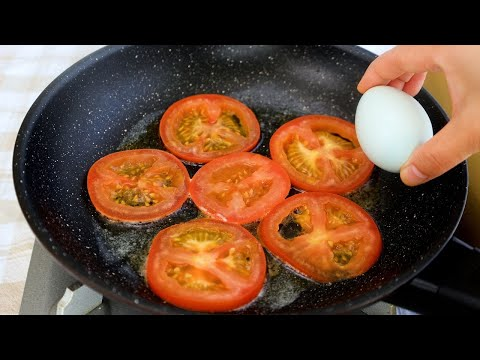

Ingredients:

- 3 eggs
- Salt
- Black pepper
- Crushed red pepper
- 100g green onion, chopped
- 1 tablespoon unsalted butter
- 1 tomato, sliced
- Mozzarella cheese

Instructions:

1. In a bowl, mix the eggs, salt, black pepper, and crushed red pepper.
2. Add the chopped green onion and mix well.
3. Heat a non-stick pan over medium-low heat and add the butter.
4. Place the tomato slices in the pan and pour the egg mixture over them.
5. Sprinkle the mozzarella cheese on top.
6. Fry for 3-5 minutes, or until the eggs are set and the cheese is melted.
7. Serve immediately.

Video ID: 9-ODDKHRVkA
Title: The Best Scrambled Eggs You&#39;ll Ever Make (Restaurant-Quality) | Epicurious 101


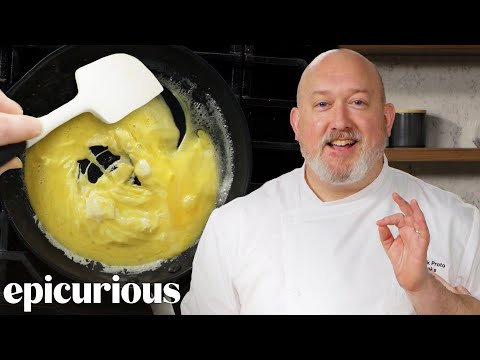

**Ingredients:**

* 3 eggs
* 1 tablespoon unsalted butter
* Salt and black pepper to taste

**Instructions:**

1. Take the eggs out of the fridge 15-20 minutes before cooking.
2. Whisk the eggs with a fork until just combined.
3. Preheat a non-stick pan over medium heat.
4. Add the butter to the pan and let it coat the bottom.
5. Pour the eggs into the pan.
6. Use a spatula to gently move the eggs around the pan, bringing them into the center.
7. Cook the eggs until they are no longer liquidy but still slightly creamy and shiny.
8. Remove the eggs from the pan and season with salt and black pepper.
9. Serve immediately.

**Tips:**

* To make large curds, cook the eggs slowly and gently.
* To make small curds, cook the eggs quickly and vigorously.
* Don't overcook the eggs or they will become dry and rubbery.
* For extra richness, add a knob of butter to the eggs after they are cooked.



In [ ]:
# Search YouTube and display results
search_response = search_yt('egg recipes', max_results=2)
videos_info = display_yt_results(search_response, 'Extract cooking recipe from video transcript: ')

In [ ]:
# Go to next page
search_response = search_yt('egg recipes', max_results=2, page_token=search_response.next_page_token)
display_yt_results(search_response, extract_prompt='Extract cooking recipe from video transcript: ')

In [ ]:
save_recipe(videos_info['3s7opUfsin8'])

Recipe saved.


Result: 0
1 Tomato with 3 eggs! Quick breakfast in 5 minutes. Super easy and delicious omelet recipe


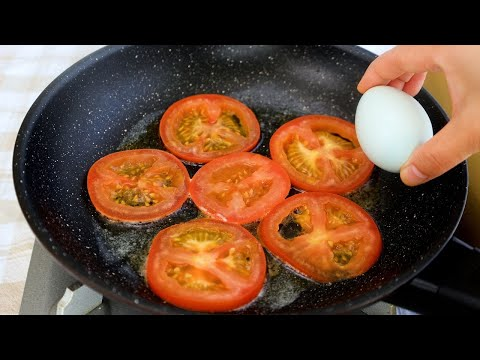

Ingredients:

- 3 eggs
- Salt
- Black pepper
- Crushed red pepper
- 100g green onion, chopped
- 1 tablespoon unsalted butter
- 1 tomato, sliced
- Mozzarella cheese

Instructions:

1. In a bowl, mix the eggs, salt, black pepper, and crushed red pepper.
2. Add the chopped green onion and mix well.
3. Heat a non-stick pan over medium-low heat and add the butter.
4. Place the tomato slices in the pan and pour the egg mixture over them.
5. Sprinkle the mozzarella cheese on top.
6. Fry for 3-5 minutes, or until the eggs are set and the cheese is melted.
7. Serve immediately.

Result: 1
Easy Tuscan Salmon Recipe - 30 Minute Salmon Dinner!


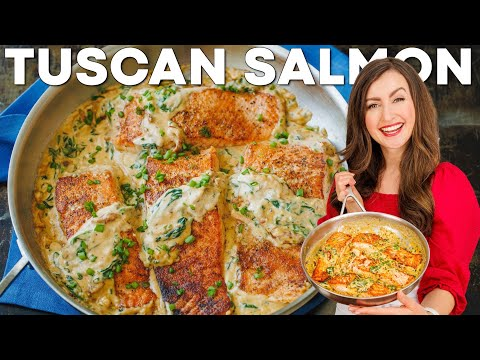

**Tuscan Salmon**

**Ingredients:**

* 1.5 to 2 pounds boneless and skinless salmon fillets
* Salt, to taste
* Garlic powder, to taste
* Freshly cracked black pepper, to taste
* 2 tablespoons olive oil
* 2 tablespoons butter
* 1/2 cup sun dried tomatoes, chopped
* 2 cloves garlic, minced
* 1/2 cup chopped chives or green onion
* 1 cup heavy cream
* 1/2 cup grated Parmesan cheese
* 1/2 cup baby spinach leaves

**Instructions:**

1. Season the salmon fillets with salt, garlic powder, and black pepper.
2. Heat the olive oil and butter in a large non-reactive skillet over medium heat.
3. Add the salmon fillets and saute for 3 to 5 minutes per side, or until cooked through.
4. Transfer the salmon fillets to a platter and tent with foil to keep warm.
5. Add the sun dried tomatoes, garlic, and chives to the skillet. Saute for 1 minute, then add the heavy cream and Parmesan cheese.
6. Bring the mixture to a light boil, then reduce the heat and let simmer for 1 minute, or until thickened.
7. St

In [ ]:
query_results = search_recipedb('chicken')